In [1]:
import os
import cv2
import sys
import cc3d
import torch
import random
import shutil
import tifffile
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from scipy import misc
from libtiff import TIFF
from einops import rearrange
from scipy.cluster.vq import kmeans,vq,whiten
from skimage.morphology import skeletonize,thin




def read_tiff_stack(file):
    img = Image.open(file)
    images = []
    for i in range(img.n_frames):
        img.seek(i)
        slice = np.array(img)
        images.append(slice)
    return np.array(images)  


def read_tiff_files(root):
    res = []
    for f in sorted(os.listdir(root)):
        res.append(np.array(Image.open(path(root, f))))
    return np.array(res)  


def path(*args):
    return os.path.join(*args)


def rmtree(path):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.mkdir(path)



## Mesh grid

<Figure size 1080x1440 with 0 Axes>

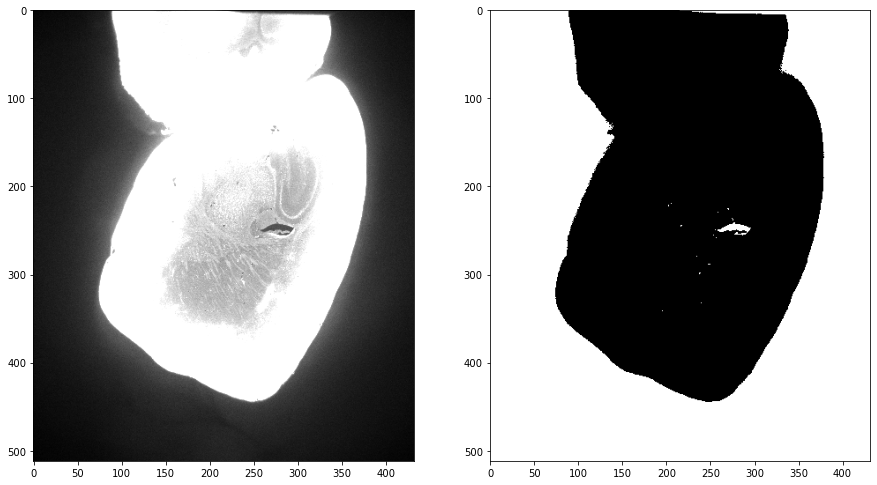

In [6]:
rescale = 0.2

# file = "/media/root/lzy_data/190628_647_0-8x_28xdynamicfocussing_newcap_13-06-59/" \
#         "13-06-59_647_0-8x_28xdynamicfocussing_newcap_UltraII_C00_xyz-Table Z0717.ome.tif"
file = "/media/root/6701ae9d-6612-4271-8d50-522d7f72528b/szy/projects/data/" \
        "190312_647_LP100_ET200_Z08_HF20_14-14-10/14-14-10_647_LP100_ET200_Z08_HF20_UltraII_C00_xyz-Table Z0956.ome.tif"
img = read_tiff_stack(file)[0]
height, width = int(img.shape[0] * rescale), int(img.shape[1] * rescale)
img = cv2.resize(img, (width,height))
img_rect = cv2.convertScaleAbs(img,alpha=0.05,beta=0).astype(np.float64).copy()
img = cv2.convertScaleAbs(img,alpha=0.1,beta=0).astype(np.float64)
plt.figure(figsize=(15,20))


K = 2
spot = []
flattened_img = img.flatten()
for i in flattened_img:
    spot.append(i)

''' --------- do clustering ---------'''
spot = whiten(spot)
# print(spot)
center,_ = kmeans(spot,K)
cluster,_ = vq(spot,center)

res = cluster.reshape(height, width)
plt.figure(figsize=(15,20))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.subplot(122)
plt.imshow(res, cmap='gray')

clus = res[:, len(res)//2]

if len(clus[clus == 0]) > len(res)//2:
    res = 1 - res

(512, 432, 3)


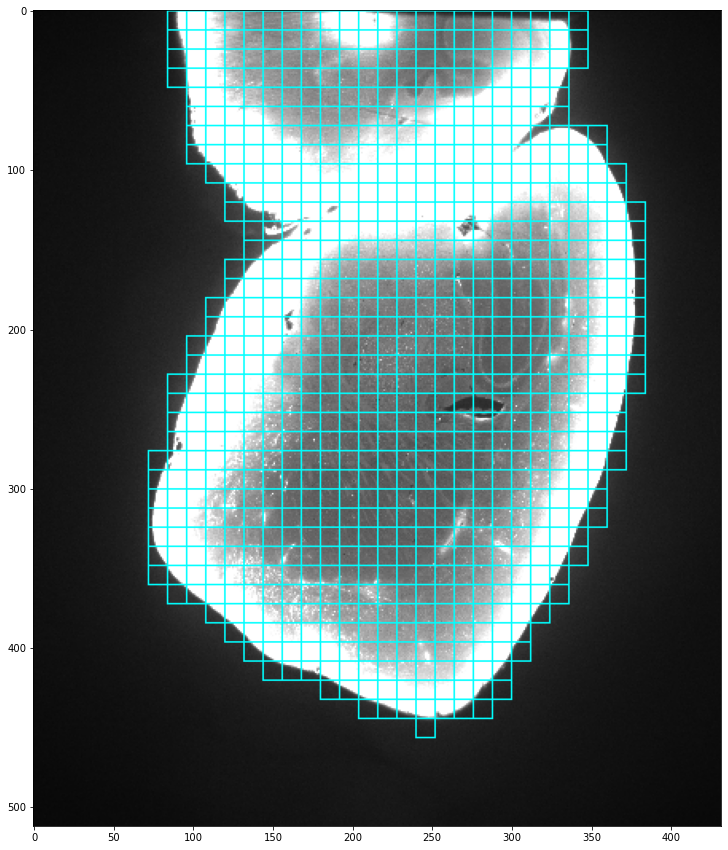

In [7]:
patch = int(64 * rescale)
img_rect_color = np.stack((img_rect, img_rect, img_rect))
img_rect_color = np.transpose(img_rect_color, (1,2,0)).astype(np.uint8)
img_rect_res = img_rect_color.copy()
print(img_rect_res.shape)
for i in range(0, height - patch, patch):
    for j in range(0, width - patch, patch):
        if res[i: i + patch, j: j + patch].sum() > 0:
            img_rect_res = cv2.rectangle(img_rect_res, (j,i), (j+patch,i+patch), (0,255,255), 1)
plt.figure(figsize=(15,15))
plt.imshow(img_rect_res)

## Make dataset

#### 切cube

In [2]:
command = 'python ./tiffcropper.py' \
            ' -s /media/root/data3/szy/data/190313_647_LP100_ET200_Z08_HF20_14-18-27/' \
            ' -t /media/root/data3/szy/tst/' \
            ' -c /media/root/data3/szy/r141827-1.csv' \
            ' -i 1450' \
#             ' --label' 
            
# os.system(command)

#### 去除离散voxel

In [3]:
# def thined_component(stack, vol):
#     labels = cc3d.connected_components(stack)
#     for i in tqdm(range(1, labels.max())):
#         label = labels == i
#         if label.astype(np.int).sum() < vol:
#             labels[label] = 0
#     labels[labels > 0] = 255
#     return labels
def thined_component(stack, vol):    
    labels = cc3d.connected_components(stack)
    shapes = labels.shape
    labels = labels.flatten()
    mark = [0] * (labels.max() + 1)
    for i in labels:
        mark[i] += 1
    for k in range(len(labels)):
        if mark[labels[k]] < vol:
            labels[k] = 0
    labels[labels > 0] = 255

    return labels.reshape(shapes)

def save_decomponent_volume(root, target, vol=400):
    stack = TIFF.open(root, mode='r') 
    volume = []
    for img in tqdm(list(stack.iter_images())):
        img = np.array(img)
        volume.append(img) 
    volume = np.array(volume)
    volume[volume > 100] = 255
    volume[volume <= 100] = 0
    print(volume.shape)
    tifffile.imsave(target + '/segment_res_cc3d.tif', thined_component(volume,vol))   
      

def save_decomponent_volume_batch(root, target, vol=15):
    for f in os.listdir(root):
        stack = TIFF.open(os.path.join(root, f), mode='r') 
        volume = []
        for img in list(stack.iter_images()):
            img = np.array(img)
            volume.append(img) 
        volume = np.array(volume)
        volume[volume > 100] = 255
        volume[volume <= 100] = 0
        tifffile.imsave(os.path.join(target, f), thined_component(volume,vol))   
    

save_decomponent_volume("/media/root/6701ae9d-6612-4271-8d50-522d7f72528b/szy/projects/Neuronmap/data/141410-semi/segment_res.tif",
                       "/media/root/6701ae9d-6612-4271-8d50-522d7f72528b/szy/projects/Neuronmap/data/141410-semi/", vol=100)
# save_decomponent_volume_batch('/media/root/data4/szy/validate/141410/junk_labels_rectified/', '/media/root/data4/szy/validate/141410/junk_labels_rectified/')


#### 自动标注（效果不稳定）

In [153]:
def high_light(img):
    im = img.astype(np.float64)
# #     blurred = cv2.GaussianBlur(im, (3,3), 20)
    blurred = cv2.blur(im, (2,2))
    im = im - blurred
    im[im < 0] = 0
#     plt.imshow(im, cmap = 'gray') 
    im = (im - im.min()) / (im.max() - im.min())
    z, height, width = img.shape
    flattened_img = im.flatten()
    spot = []
    for i in flattened_img:
        spot.append(i)

    ''' --------- do clustering ---------'''
    spot = whiten(spot)
    center,_ = kmeans(spot, 2)
    cluster,_ = vq(spot,center)
    res = cluster.reshape(z ,height, width)
#     im = cv2.convertScaleAbs(im,alpha=0.8,beta=0.45).astype(np.float64)
    if res.sum() > 150*150*150 // 2:
        res = 1 - res
    return (res * 65535).astype(np.uint16)

root = "/media/data2/szy/Axon/val/volumes/"
target = "/media/data2/szy/Axon/val/labels/"
# root = "/media/data2/szy/crop/"
# target = "/media/data2/szy/labels/"
# for i in os.listdir(root):
#     volume = read_tiff_stack(os.path.join(root, i))
#     volume = high_light(volume)
#     tifffile.imsave(os.path.join(target, i), thined_component(volume, 20))
    
for i in os.listdir(root):
    volume = read_tiff_stack(os.path.join(root, i))
    im = volume.astype(np.float64)
# #     blurred = cv2.GaussianBlur(im, (3,3), 20)
    blurred = cv2.blur(im, (2,2))
    volume = volume - blurred
    volume[volume<0] = 0
    tifffile.imsave(os.path.join(target, i.replace('volume','label')), volume.astype(np.uint16))

#### 批量skeleton

In [4]:
def gaussian(x, kernal, flg_min):
    x = cv2.blur(x, (kernal, kernal))
    mi = x.min()
    mx = x.max()
    imin = flg_min * mx + (1 - flg_min) * mi
    
    return x

    #.cpu()[0][0]).astype(np.uint8)
base = "/media/root/data4/szy/validate/155829/junk_labels_rectified/"
target = "/media/root/data4/szy/validate/155829/junk_labels_skeleton/"
# thinned_partial = thin(labels, max_iter=2)

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

def sekeleton_batch(base, target, device):
    for pth in tqdm(os.listdir(base)):
        labels = read_tiff_stack(base + pth)
        labels = thined_component(labels, 50)
    #     labels = gaussian(labels, 2, 0.8)

        skeleton = skeletonize(labels)
        x =  torch.Tensor(skeleton.reshape(1,1,*skeleton.shape)).to(device)
        p1 = torch.nn.functional.max_pool3d(x, (3, 1, 1), 1, (1, 0, 0))
        p2 = torch.nn.functional.max_pool3d(x, (1, 3, 1), 1, (0, 1, 0))
        p3 = torch.nn.functional.max_pool3d(x, (1, 1, 3), 1, (0, 0, 1))
        min_pool_x = torch.min(torch.min(p1, p2), p3)
        x = torch.max(torch.max(p1, p2), p3)

    #     x = gaussian(np.array(x.cpu()[0][0]).astype(np.uint8), 2, 0.5)
    #     x = (x - x.min()) / (x.max() - x.min()) * 255
        x = np.array(x.cpu()[0][0]).astype(np.uint8)

        x[x > 0] = 255
        x[x <= 0] = 0

        tifffile.imsave(target + pth, x.astype(np.uint8))
    
    print('Done.')

#### 制作验证集

In [97]:
def gauss_cal(img):
    im = img.astype(np.float64)
#     blurred = cv2.GaussianBlur(im, (3,3), 20)
    blurred = cv2.blur(im, (2, 2))
    im = im - blurred
#     plt.imshow(im, cmap = 'gray') 
    im[im < 0] = 0
    return im.astype(np.uint16)

# x, y, zslice = [450, 1050, 1040]
# name_of_brain = '141410'
# root = "/media/root/6701ae9d-6612-4271-8d50-522d7f72528b/szy/projects/data/190312_647_LP100_ET200_Z08_HF20_14-14-10/"

x, y, zslice = [500, 920, 700]
name_of_brain = '155829'
root = "/media/root/6701ae9d-6612-4271-8d50-522d7f72528b/szy/projects/data/190702_647_0-8x_28xdynamicfocussing_newcap_15-58-29/"


base = "/media/root/data4/szy/validate/"

if not os.path.exists(path(base, name_of_brain)):
    os.mkdir(path(base, name_of_brain))
    
whole_root = path(base, name_of_brain, name_of_brain + "_whole")
patch = 600
z_gap = 450
crop = []

In [98]:
'''
cropping a whole volume based on a start point

'''
rmtree(whole_root)

for idx, f in enumerate(sorted(os.listdir(root))[zslice: zslice + z_gap]):
    img = np.array(Image.open(path(root, f))).astype(np.uint16)
    cropped = img[y: y+patch, x: x+patch]
    tifffile.imsave(path(whole_root, str(idx).zfill(4)) + '.tiff', cropped)

In [102]:
'''
turning the whole volume into small cubes in order

'''
rect = 150
patch = 600
volume_target = path(base, name_of_brain, name_of_brain + "_volumes")
label_target = path(base, name_of_brain, name_of_brain + "_labels")
# for i in range((patch // rect) ** 2 * (z_gap // rect)):
#     os.mkdir(path(volume_target, str(i)))
    
whole_volume = read_tiff_files(whole_root)
rmtree(volume_target)
rmtree(label_target)
print(whole_volume.shape)
whole_volume = rearrange(whole_volume, '(z p_z)(h p_h)(w p_w) -> (z h w) p_z p_h p_w',p_h = rect, p_w = rect, p_z = rect)  
for idx, v in enumerate(whole_volume):
    tifffile.imsave(path(volume_target, str(idx).zfill(3) + '.tiff'), v)
    tifffile.imsave(path(label_target, str(idx).zfill(3) + '.tiff'), gauss_cal(v))

(450, 600, 600)


In [135]:
val_base = '/media/root/data4/szy/validate/155829/'

'''
junk label itk-snap rectifying

'''
def rectify_label(pth, rec_pth):    
    labels = read_tiff_stack(pth)
    rec_tif = read_tiff_stack(rec_pth)
    
    labels[rec_tif==1] = 0
    labels[rec_tif==2] = 255
    return labels
    
pth = path(val_base, 'junk_labels')
rec_pth = path(val_base, 'itksnap_rec')
target = path(val_base, 'junk_labels_rectified')
whole_target = path(val_base, 'whole_label')
fst_labels = path(val_base, 'labels')
whole_rect_label = path(val_base, 'rect_label')

In [ ]:
for f in os.listdir(pth):
    file = path(pth, f)
    rec_file = path(rec_pth, f)
    out_file = path(target, f)
    tifffile.imsave(out_file, rectify_label(file, rec_file))

In [37]:
'''
filling the pure junk labels with blank volume

'''
for i in range(48):
    fname = str(i).zfill(3) + '.tif'
    if not os.path.exists(path(target,fname)):
        tifffile.imsave(path(target, fname), np.zeros((150,150,150)).astype(np.uint8))

In [134]:
'''
get all junks of the whole volume

'''
all_rects = []
for i in range(48):
    fname = str(i).zfill(3) + '.tif'
    pth = path(rec_pth,fname)
    if not os.path.exists(pth): # not rectified
        if not os.path.exists(path(fst_labels,fname)): 
            all_rects.append(np.ones((150,150,150)).astype(np.uint8))
        else:
            all_rects.append(np.zeros((150,150,150)).astype(np.uint8))
    else:
        all_rects.append(read_tiff_stack(pth).astype(np.uint8))
all_rects = np.array(all_rects)
whole_rect = rearrange(all_rects, '(z h w) p_z p_h p_w-> (z p_z)(h p_h)(w p_w)',z = 3, h = 4, w = 4)  
tifffile.imsave(path(whole_target,'rect_label.tiff'), whole_rect.astype(np.uint8))

In [5]:
'''
remove the noisy voxels from all volumes

'''
save_decomponent_volume_batch(target, target)

'\nremove the noisy voxels from all volumes\n\n'

In [56]:
whole_target = path(val_base, 'whole_label')
whole = []

for f in sorted(os.listdir(target)):
    whole.append(read_tiff_stack(path(target, f)))
whole = np.array(whole)
whole.shape
whole_volume = rearrange(whole, '(z h w) p_z p_h p_w-> (z p_z)(h p_h)(w p_w)',z = 3, h = 4, w = 4)  
tifffile.imsave(path(whole_target,'label.tiff'), whole_volume.astype(np.uint8))

## 3d data resize

In [17]:
def save_resized_tiff_by_scale(root, target, scales, mod='single'):
    images = []
    scale_x, scale_y, scale_z = scales
    if mod == 'single': 
        stack = TIFF.open(root, mode='r') 
        _y, _x = np.array(list(stack.iter_images())[0]).shape
        for img in list(stack.iter_images()):
            img = np.array(img)
            img = cv2.resize(img, (int(_x * scale_x), int(_y * scale_y)))
            images.append(img)      
    elif mod == 'stack':
        _y, _x = np.array(Image.open(os.path.join(root, sorted(os.listdir(root))[0]))).shape
        for i in sorted(os.listdir(root)):
            img = Image.open(os.path.join(root, i))
            img = np.array(img)
            img = cv2.resize(img, (int(_x * scale_x), int(_y * scale_y)))
#             tifffile.imsave(root2 + f'/{i}.tiff', img.transpose((1,0)))
            images.apppend(img)
    images = np.array(images).transpose((2, 1, 0))
    _y, _z = images[0].shape
    res_img = np.array([cv2.resize(im, (int(_z * scale_z), _y)) for im in images]).astype(np.uint32)
    tifffile.imsave(target, res_img.transpose((2, 1, 0)))
    
    
def save_resized_tiff_by_shape(root, target, shapes, mod='single'):
    images = []
    shape_x, shape_y, shape_z = shapes
    if mod == 'single':
        stack = TIFF.open(root, mode='r')
        for img in tqdm(list(stack.iter_images())):
            img = np.array(img).astype(np.uint16)
            img = cv2.resize(img, (shape_x, shape_y))
            images.append(img)      
    elif mod == 'files':
        for i in tqdm(sorted(os.listdir(root))):
            img = Image.open(os.path.join(root, i))
            img = np.array(img)
            img = cv2.resize(img, (shape_x, shape_y))
#             tifffile.imsave(root2 + f'/{i}.tiff', img.transpose((1,0)))
            images.append(img)
    images = np.array(images).transpose((2, 1, 0))
    _y, _z = images[0].shape
    res_img = np.array([cv2.resize(im, (shape_z, _y)) for im in images]).astype(np.uint16)
    tifffile.imsave(target, res_img.transpose((2, 1, 0)).transpose((0, 2, 1)))
    
      
def save_resized_tifs_by_shape(root, target, shapes, mod='single'):
    images = []
    shape_x, shape_y = shapes
    if mod == 'single':
        stack = TIFF.open(root, mode='r')
        for img in tqdm(list(stack.iter_images())):
            img = np.array(img).astype(np.uint8)
            img = cv2.resize(img, (shape_x, shape_y))
            tifffile.imsave(target + i, img)      
    elif mod == 'files':
        for i in tqdm(sorted(os.listdir(root))[800:1200]):
            img = Image.open(os.path.join(root, i))
            img = np.array(img)
            img = cv2.resize(img, (shape_x, shape_y))
#             tifffile.imsave(root2 + f'/{i}.tiff', img.transpose((1,0)))
            tifffile.imsave(target + i, img)   
    
    
def resize_3d(stack, scales):
    scale_x, scale_y, scale_z = scales
    images = [cv2.resize(img, (int(_x * scale_x), int(_y * scale_y))) for img in stack]
    _y, _z = images[0].shape
    res_img = np.array([cv2.resize(im, (int(_z * scale_z), _y)) for im in images]).astype(np.uint32)
    return res_img.transpose((2, 1, 0))



In [11]:
save_resized_tifs_by_shape(root="/media/root/6701ae9d-6612-4271-8d50-522d7f72528b/szy/projects/data/190702_647_0-8x_28xdynamicfocussing_newcap_15-58-29/",
                           target='/media/root/01a3fb01-7912-492d-9561-d36a4da2ffef/szy/Cycle-dataset/trainA/', 
                           shapes=[2160, 2560],
                           mod='files')

# save_resized_tifs_by_shape(root="/media/data1/szy/data/190312_647_LP100_ET200_Z08_HF20_14-14-10/",
#                            target='/media/root/01a3fb01-7912-492d-9561-d36a4da2ffef/szy/Cycle-dataset/trainB/', 
#                            shapes=[2160, 2560],
#                            mod='files')

100%|█████████████████████████████| 400/400 [00:31<00:00, 12.73it/s]


In [168]:
save_resized_tiff_by_scale(root='/media/data1/szy/projects/Neuronmap/data/125049/segment_res.tif',
                           target='/media/data1/szy/projects/Neuronmap/data/125049/resized_res_1.tif', 
                           scales=[0.3, 0.3, 0.3],
                           mod='single')

In [155]:
save_resized_tiff_by_scale(root='/media/data1/szy/projects/Neuronmap/data/190312-max-2/segment_res.tif',
                           target='/media/data1/szy/projects/Neuronmap/data/190312-max-2/resized_res.tif', 
                           scales=[0.35, 0.35, 0.35],
                           mod='single')

In [46]:
root = '/media/data1/szy/projects/Neuronmap/data/1901008-125049/trans.tiff'
target = '/media/data1/szy/projects/Neuronmap/data/1901008-125049/rotate_trans.tiff'
stack = TIFF.open(root, mode='r')
images = []
for img in tqdm(list(stack.iter_images())):
    img = np.array(img).astype(np.uint8)
    images.append(img)  
images = np.fliplr(np.rot90(np.array(images).transpose(0,2,1),1))
tifffile.imsave(target, images)


100%|██████████| 320/320 [00:00<00:00, 11569.00it/s]


In [18]:
import random

input_dim = 256
root = '/media/root/01a3fb01-7912-492d-9561-d36a4da2ffef/szy/Cycle-dataset/trainA/'
target = '/media/root/01a3fb01-7912-492d-9561-d36a4da2ffef/szy/Cycle-dataset/trainA1/'
idx = 0
for i in tqdm(sorted(os.listdir(root))):
    img = Image.open(os.path.join(root, i))
    img = np.array(img)
    for _ in range(2):
        x = random.randint(0, img.shape[0] - input_dim)
        y = random.randint(0, img.shape[1] - input_dim)
    #             tifffile.imsave(root2 + f'/{i}.tiff', img.transpose((1,0)))
        tifffile.imsave(target + i.replace('.tif','') + str(idx)+'.tif', img[x:x + input_dim, y:y + input_dim])   
        idx += 1
        

# input_dim = 256
# root = '/media/root/01a3fb01-7912-492d-9561-d36a4da2ffef/szy/Cycle-dataset/trainB/'
# target = '/media/root/01a3fb01-7912-492d-9561-d36a4da2ffef/szy/Cycle-dataset/trainB1/'
# idx = 0
# for i in tqdm(sorted(os.listdir(root))):
#     img = Image.open(os.path.join(root, i))
#     img = np.array(img)[:,168:1958]
#     for _ in range(2):
#         x = random.randint(0, img.shape[0] - input_dim)
#         y = random.randint(0, img.shape[1] - input_dim)
#     #             tifffile.imsave(root2 + f'/{i}.tiff', img.transpose((1,0)))
#         tifffile.imsave(target + i.replace('.tif','') + str(idx)+'.tif', img[x:x + input_dim, y:y + input_dim])   
#         idx += 1

100%|█████████████████████████████| 400/400 [00:06<00:00, 64.50it/s]


## elastix配准

In [48]:
def main():
    '''transform'''
    m_image_path = r"/media/data1/szy/projects/Neuronmap/data/1901008-125049/resized_res.tif"
    transform_dir = r"/media/data1/szy/projects/Neuronmap/data/1901008-125049/transform/"
    output_path = r"/media/data1/szy/projects/Neuronmap/data/1901008-125049/transform/"
    transform(m_image_path, output_path, transform_dir)

def transform(m_path, output, transform_dir):
    if not os.path.exists(output):
        os.mkdir(output)
    param_list = []

    for i in range(len(os.listdir(transform_dir))):
        param_list.append(os.path.join(transform_dir, str(i), "TransformParameters.0.txt"))

    for i, param in enumerate(param_list):
        if not os.path.exists(os.path.join(output, str(i))):
            os.mkdir(os.path.join(output, str(i)))
        command = f"transformix -in {m_path} -out {os.path.join(output, str(i))} -tp {param}"
        os.system(command)
        m_path = os.path.join(output, str(i), "result.mhd")
    return m_path

main()


In [16]:
def transform(image_path,
              trans_matrix_dir):
    import torch
    from torch.nn.functional import grid_sample
    img = read_tiff_stack(image_path)
    print(img.dtype)
    img = img[np.newaxis, np.newaxis, ...]
    deform_list = []
    img = torch.Tensor(img)

    trans_matrix_path_list = [os.path.join(trans_matrix_dir,
                             "{}_retrans.npy".format(i))
                              for i in range(3)]
    for file in trans_matrix_path_list:
        deform_image = np.load(file)
        assert img.shape[-3:] == deform_image.shape[:-1]
        deform_list.append(torch.Tensor(deform_image[np.newaxis, ...]))
        img = grid_sample(img, deform_list[-1])
    return img.numpy().squeeze().astype(np.uint8)

def read_tiff_stack(path):
    img = Image.open(path)
    images = []
    for i in range(img.n_frames):
        img.seek(i)
        slice = np.array(img)
        images.append(slice)

    return np.array(images)

def write_tiff_stack(vol, fname):
    im = Image.fromarray(vol[0])
    ims = []

    for i in range(1, vol.shape[0]):
        ims.append(Image.fromarray(vol[i]))

    im.save(fname, save_all=True, append_images=ims)
    
dir = "/media/data1/szy/projects/Neuronmap/data/1901008-125049/"
trans_img = transform(dir + "resized_res.tif",
                      "/media/data1/zht/Recursive_network_pytorch/2021-06-30_13-59-43/191008_647_0-8x_28xdynamicfocussing_newcap_12-50-49/")
write_tiff_stack(trans_img, os.path.join(dir, "trans.tiff"))


int32


## 数据增强

#### 随机降低对比度

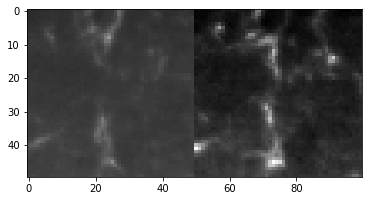

In [274]:
begin = np.array([20, 20, 20])
end = np.array([70, 70, 70])
mid_p = (begin + end) // 2 
image = im[begin[0]: end[0], begin[1]: end[1], begin[2]: end[2]]
mean = image.mean()
image_contr = image + (mean - image) * 0.6
plt.imshow(np.concatenate((image_contr[mid_p[0]], image[40]), axis = 1), cmap='gray')
# plt.imshow(image_contr[40],cmap='gray')
# print((mean - im))

86.60254037844386


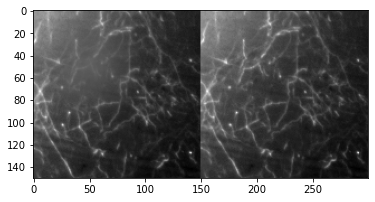

In [330]:
im = read_tiff_stack('/media/data1/szy/projects/data/Axons/train/volumes/volume-0021.tif')
raw = im.copy()

mid = np.array([50, 50, 30])
length = 50
image = im[mid[0] - length: mid[0] + length, 
           mid[1] - length: mid[1] + length,
           mid[1] - length: mid[1] + length]
mean = image.mean()
d = np.meshgrid(range(2 * length),range(2 * length), range(2 * length))
lam = 0.9

matrix = ((d[0] - length) ** 2 + (d[1] - length) ** 2 + (d[2] - length) ** 2) ** (1 / 2)
print(matrix.max())
matrix[matrix > length] = length

matrix = (1 - matrix / length) * lam
res = image + matrix * (mean - image)

im[mid[0] - length: mid[0] + length, 
           mid[1] - length: mid[1] + length,
           mid[1] - length: mid[1] + length] = res
plt.imshow(np.concatenate((im[mid[0]], raw[mid[0]]), axis = 1), cmap='gray')
# plt.imshow(np.concatenate((im[20], raw[20]), axis = 1), cmap='gray')

In [449]:
def random_weaken_contrast(im, mid_points, rad, sigma=0.8):
    for mid in mid_points:
        image = im[mid[0] - rad: mid[0] + rad, 
                   mid[1] - rad: mid[1] + rad,
                   mid[1] - rad: mid[1] + rad]
        mean = image.mean()
        d = np.meshgrid(range(2 * rad),range(2 * rad), range(2 * rad))

        matrix = ((d[0] - rad) ** 2 + (d[1] - rad) ** 2 + (d[2] - rad) ** 2) ** (1 / 2)
    #     print(matrix.max())
        matrix[matrix > rad] = rad

        matrix = (1 - matrix / rad) * sigma
        res = image + matrix * (mean - image)

        im[mid[0] - rad: mid[0] + rad, 
           mid[1] - rad: mid[1] + rad,
           mid[1] - rad: mid[1] + rad] = res
    return im

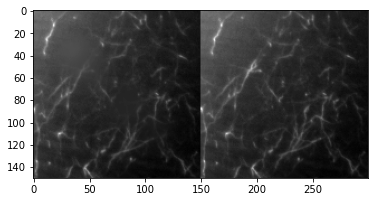

In [457]:
import random
volume = read_tiff_stack('/media/data1/szy/projects/data/Axons/train/volumes/volume-0021.tif')
label = read_tiff_stack('/media/data1/szy/projects/data/Axons/train/labels/annotation-0021.tif')

def contrast_augmentation(volume, label, rad=25, N=10):
    raw = volume.copy()
    center_cube = label[rad: -rad, rad: -rad, rad: -rad]
    zxis, xxis, yxis = np.where(center_cube == 255)
    rands = random.sample(range(0,len(zxis)), N)
    mid = [[zxis[rand] + rad, xxis[rand] + rad, yxis[rand] + rad] for rand in rands]
    img_weakened = random_weaken_contrast(volume, mid, rad)
    
    plt.imshow(np.concatenate((img_weakened[mid[0][0]], raw[mid[0][0]]), axis = 1), cmap='gray')
    
contrast_augmentation(volume, label)

#### 直方图匹配

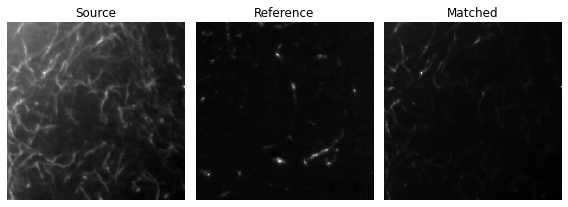

0.40401312275883117

In [49]:
import matplotlib.pyplot as plt

from skimage import exposure
from skimage.exposure import match_histograms

image = read_tiff_stack('/media/root/6701ae9d-6612-4271-8d50-522d7f72528b/szy/projects/data/Axons/train/volumes/volume-0021.tif') / 65535
reference = read_tiff_stack("/media/data2/szy/Axon/train/volumes/volume-8005.tiff") / 65535

matched = match_histograms(image, reference)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)
for aa in (ax1, ax2, ax3):
    aa.set_axis_off()

    
idx = 40
ax1.imshow(image[idx], cmap='gray')
ax1.set_title('Source')
ax2.imshow(reference[idx], cmap='gray')
ax2.set_title('Reference')
ax3.imshow(matched[idx], cmap='gray')
ax3.set_title('Matched')

plt.tight_layout()
plt.show()
matched.max()

## Heatmap

In [58]:
import nrrd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

ANO, metaANO = nrrd.read('annotation_25.nrrd')

def edge_demo(image):
    blurred = cv2.GaussianBlur(image, (3, 3), 0)
    gray = cv2.cvtColor(blurred, cv2.COLOR_RGB2GRAY)
    edge_output = cv2.Canny(gray, 1, 20)
    return edge_output

# src = cv2.imread('./output/ano_coronal.png')

# plt.imshow(edge_demo(src),cmap='gray')
grid_graph = []
for i in tqdm(range(ANO.shape[0])):
    slice = ANO[i,:,:].astype(float)
    slice /= 2000
    im = np.uint8(plt.cm.jet(slice)*255)
    grid_graph.append(edge_demo(im))

tifffile.imsave('./graph.tiff', np.array(grid_graph))

100%|██████████| 528/528 [00:04<00:00, 126.17it/s]


(528, 320, 456, 3)
154


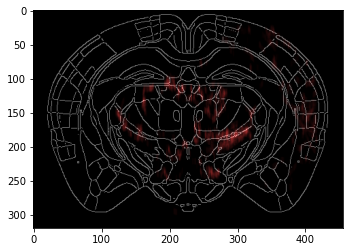

In [110]:
graph =  np.array(grid_graph) * 0.5
# B G R
graph_BGR = np.stack([graph, graph, graph], -1).astype(np.uint16)
print(graph_BGR.shape)
# graph = cv2.cvtColor(graph, cv2.COLOR_GRAY2BGR)

# ANO[40,:,:]


kernal = 9
x = cv2.blur(images, (kernal, kernal))
x_BGR = np.stack([x * 3,x * 0.8,x * 0.8], -1).astype(np.uint16)

x_BGR += graph_BGR

print(x.max())
x_BGR[x_BGR > 255] = 255

plt.imshow(x_BGR[300], cmap='gray')
tifffile.imsave('./x.tiff', np.array(x_BGR).astype(np.uint8))

In [99]:
c = cv2.imread('./output/ano_coronal.png')
c.shape

(320, 456, 3)

## SWC to Raw

In [224]:
import tifffile

res = np.zeros((150, 150, 150))
with open('/media/data2/szy/Tracing.swc', 'r') as f:
    start_idx = 3
    lines = f.readlines()
    nodes = {'1': [float(n) for n in lines[start_idx].split(' ')[2:5]]}
    for line in lines[start_idx + 1:]:
        node = line.strip('\n').split(' ')
        coord = [round(float(n)) for n in node[2:5]]
        nodes[node[0]] = coord
        res[coord[2]][coord[1]][coord[0]] = 255
#         if nodes[node[-1]][2] - coord[2] > 1:
#             print(nodes[node[-1]][2] - coord[2])
tifffile.imsave('/media/data2/szy/res.tif', res.astype(np.uint8))

## Test 
<u># 背景矫正阈值后减去高频signal 然后再直方图均化</u>

In [273]:
def read_tiff_files(root):
    images = []
    for i in sorted(os.listdir(root)):
        img = Image.open(os.path.join(root, i))
        slice = np.array(img)
        images.append(slice)
    return np.array(images)

def showim(im):
    plt.figure(figsize=(20,30))
    plt.imshow(im, cmap='gray')
    
def read_im(root, indx):
    return np.array(Image.open(root + sorted(os.listdir(root))[indx])).astype(np.int16)

def histogram(im):
    imhist,bins = np.histogram(im.flatten(),65535,normed= True)
    cdf = imhist.cumsum()   #
    cdf = 65535 * cdf / cdf[-1]
    #使用累积分布函数的线性插值，计算新的像素值
    im2 = np.interp(im.flatten(),bins[:-1],cdf)
    return im2.reshape(im.shape).astype(np.int16)

root640 = '/media/data1/szy/projects/data/CTRL0208_R/181206_640_14-41-45/'
root488 = '/media/data1/szy/projects/data/CTRL0208_R/181207_488_16-20-26/'

In [280]:
indx = 1000
im640 = read_im(root640, indx)
im488 = read_im(root488, indx)
# showim(np.concatenate([im640, im488], 1))
imres = abs(im488 - im640)
# showim(imres.astype(np.uint16))

/media/data1/anaconda3/envs/sss/lib/python3.7/site-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


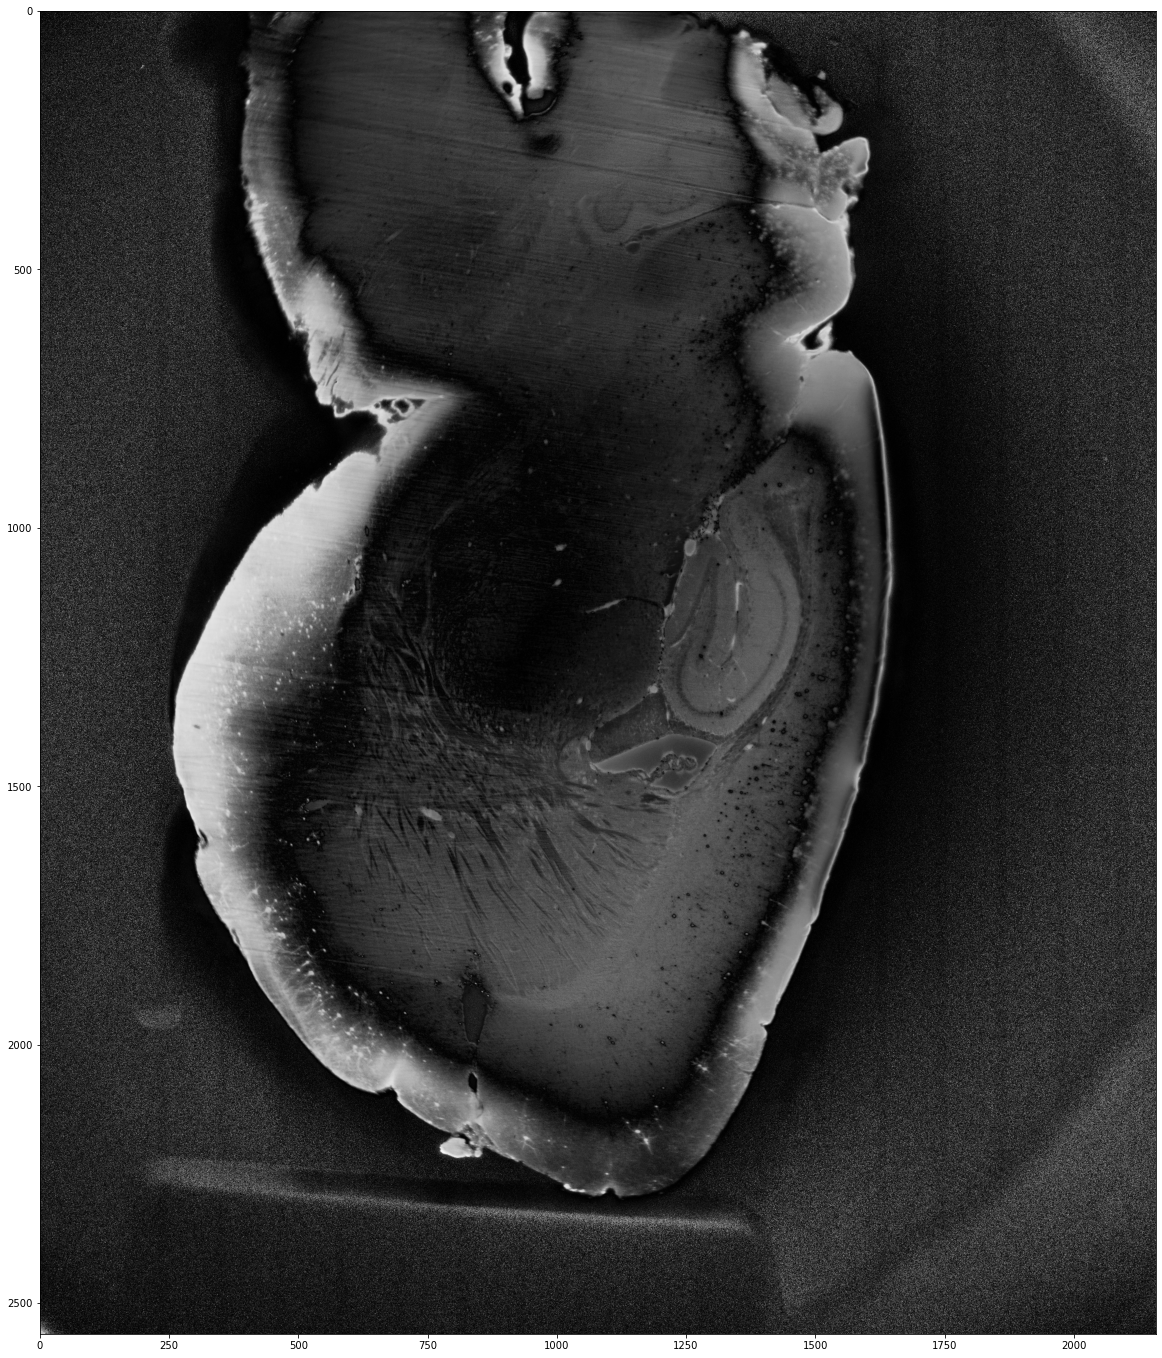

In [282]:
# imhist,bins = np.histogram(im640.flatten(),65535,normed= True)
# cdf = imhist.cumsum()   #
# cdf = 65535 * cdf / cdf[-1]
# #使用累积分布函数的线性插值，计算新的像素值
# im2 = np.interp(im488.flatten(),bins[:-1],cdf)
# im2 = im2.reshape(im.shape).astype(np.int16)
# # showim(np.concatenate([im2,im640],1))
showim(abs(histogram(im488)- histogram(im640)))

In [20]:
volume = read_tiff_stack('/media/data1/szy/projects/data/Axons/train/volumes/volume-0020.tif') / 65535
depth, width, height = volume.shape
mov = 0
mat_translation_left=np.float32([[1,0,mov],[0,1,0]])  #变换矩阵：设置平移变换所需的计算矩阵：2行3列
mat_translation_right=np.float32([[1,0,-mov],[0,1,0]])
mat_translation_up=np.float32([[1,0,0],[0,1,mov]])
mat_translation_down=np.float32([[1,0,3],[0,1,-mov]])
#[[1,0,20],[0,1,50]]   表示平移变换：其中20表示水平方向上的平移距离，50表示竖直方向上的平移距离。
res = []
for img in volume:
    dst1=cv2.warpAffine(img,mat_translation_left,(width,height),borderValue=img.mean())  #变换函数
#     dst2=cv2.warpAffine(img,mat_translation_right,(width,height),borderValue=img.mean())
#     dst3=cv2.warpAffine(img,mat_translation_up,(width,height),borderValue=img.mean())
#     dst4=cv2.warpAffine(img,mat_translation_down,(width,height),borderValue=img.mean())
    res.append((dst1))


print(res[80].max())
res = (np.array(res).astype(np.float) * volume)[80]
# res[res > 1] = 1
res = (res - res.min()) / (res.max() - res.min()) * 65535
print(res.max())
plt.imshow(volume[80])

0.5381399252307927
65535.0


/media/data1/anaconda3/envs/sss/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:
mat_translation=np.float32([[1,0,-3],[0,1,0]]
cv2.warpAffine(res[50] ,mat_translation,(width,height),borderValue=img.mean()) 

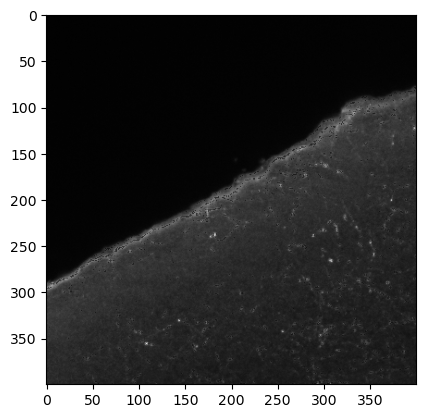

In [164]:
volumepath = '/media/root/data3/szy/brain data/crop target/volume-1010.tiff'
labelpath = '/media/root/data3/szy/brain data/crop target/label-1010-soma.tif'
v = read_tiff_stack(volumepath).astype(np.float64)
l = read_tiff_stack(labelpath)

indx = l > 0
v[indx] *= 0.4
# v = (v - v.min()) / (v.max() - v.min())
plt.imshow(v[20], cmap='gray')
plt.show()

tifffile.imsave('/media/root/data3/szy/brain data/crop target/label.tiff', v.astype(np.uint16))

#### 16张线插64

In [19]:
root = '/media/root/01a3fb01-7912-492d-9561-d36a4da2ffef/szy/Cycle-dataset/concat64/'
_root = root + 'source_B_1/'
_target = root + 'testB/'
if os.path.exists(_target):
    shutil.rmtree(_target)
os.mkdir(_target)
input_dim = 64
i= 100
for vol in os.listdir(_root):
    volume = read_tiff_stack(_root + vol)
    for _ in range(1):
        z = random.randint(0, volume.shape[0] - input_dim)
        x = random.randint(0, volume.shape[1] - input_dim)
        y = random.randint(0, volume.shape[2] - input_dim)
        volume = volume[z:z + input_dim, x:x + input_dim, y:y + input_dim].copy()
        pic = volume[range(0,input_dim,input_dim//16)].reshape(4,4,input_dim,input_dim).transpose((0,2,1,3)).reshape(input_dim*4, input_dim*4)
        tifffile.imsave(_target + str(i).zfill(4) +'.tif', pic)
        i += 1
#     break
    

In [37]:
root = '/media/root/01a3fb01-7912-492d-9561-d36a4da2ffef/szy/Cycle-dataset/concat64/'
_root = root + 'source_B_1/'
_target = root + 'train_B_200/'
if os.path.exists(_target):
    shutil.rmtree(_target)
os.mkdir(_target)
input_dim = 128
i= 100
for vol in os.listdir(_root):
    volume = read_tiff_stack(_root + vol)
    for _ in range(20):
        z = random.randint(0, volume.shape[0] - input_dim)
        x = random.randint(0, volume.shape[1] - input_dim)
        y = random.randint(0, volume.shape[2] - input_dim)
        
        volume = volume[z:z + input_dim, x:x + input_dim, y:y + input_dim].copy()
        pic = volume[random.randint(0, input_dim-1)]
        tifffile.imsave(_target + str(i).zfill(4) +'.tif', pic)
        i += 1
#     break

In [18]:

# pic = pic.reshape(256, 256)

v = volume[range(0,input_dim,input_dim//16)]
tifffile.imsave(root + 'a.tif', volume)
tifffile.imsave(root + 'b.tif', v)
save_resized_tiff_by_shape(root=root + 'b.tif',
                           target=root+'c.tif', 
                           shapes=[64,64,64],
                           mod='single')

100%|████████████| 16/16 [00:00<00:00, 21406.34it/s]


# visualization

In [196]:
dir = '/media/root/6701ae9d-6612-4271-8d50-522d7f72528b/szy/projects/data/Axons/train/volumes/volume-2010.tif'
l = '/media/root/6701ae9d-6612-4271-8d50-522d7f72528b/szy/projects/data/Axons/train/labels/annotation-2010.tif'
volume = read_tiff_stack(dir)
label = read_tiff_stack(l)

In [5]:
def equal(im, flg_max):
    flg_min = 0.01
    mi = im.min()
    mx = im.max()
    imax = flg_max * mx + (1 - flg_max) * mi
    imin = flg_min * mx + (1 - flg_min) * mi

    im[im > imax] = imax
    im[im < imin] = imin
    return (im - np.min(im))/(np.max(im) - np.min(im))

In [2]:
'''
batch overlapping volumes

'''
vroot = '/media/data2/szy/Axon/train/volumes/'
lroot = '/media/data2/szy/Axon/train/labels_sk/'
target = '/media/data2/szy/Axon/train/visualize/'

vpath = sorted(os.listdir(vroot))
lpath = sorted(os.listdir(lroot))
for vp, lp in zip(vpath, lpath):
    volume = read_tiff_stack(vroot + vp)
    label =read_tiff_stack(lroot + lp)
    vol = (equal(volume.copy(), 0.5)*255).astype(np.uint8)
#     vol = (v/65535*255).astype(np.uint8)
    vol = np.stack((vol.copy(), vol.copy(), vol.copy()), axis=3)
    lb = np.stack((label.copy()//2, label.copy(), label.copy()//2), axis=3)
    msk = np.stack((label.copy(), label.copy(), label.copy()), axis=3)
    vol[:,:,:][msk>0] //= 2
    add = vol + lb
    add[add > 255] = 255
    tifffile.imsave(target + vp, add)

In [9]:
'''
overlapping one volume and masks

'''

def color_mapping(label, rgb):
    r_channel = np.zeros_like(label)
    g_channel = r_channel.copy()
    b_channel = r_channel.copy()
    
    r_channel[label > 0] += rgb[0]
    g_channel[label > 0] += rgb[1]
    b_channel[label > 0] += rgb[2]
    return np.stack((r_channel, g_channel, b_channel), axis=3)

def add_volume_masks(vol, label1, label2, color1=(255,125,125), color2=(125,255,255)):
    vol = (equal(volume.copy(), 0.5)*255).astype(np.uint8)
    if len(volume.shape) == 3: # 1 channel grayscale
        vol = np.stack((vol.copy(), vol.copy(), vol.copy()), axis=3)
    lb1 = color_mapping(label1,color1)
    lb2 = color_mapping(label2,color2)
    vol = add_two(vol, lb1)
    vol = add_two(vol, lb2)
    return vol

def add_two(v, colored_l):
    coord = colored_l > 0
    v[coord] = v[coord] * 0.3 + colored_l[coord] * 0.7
    return v
       

In [ ]:
vroot = '/media/root/data4/szy/validate/155829/155829_whole/'
lroot1 = "/media/root/6701ae9d-6612-4271-8d50-522d7f72528b/szy/projects/Neuronmap/data/1011/segment_res.tif"
lroot2 = '/media/root/data4/szy/validate/155829/whole_label/label.tiff'
target = '/media/root/data4/szy/validate/155829/whole_label/visualize_3.tiff'
volume = read_tiff_files(vroot)
# volume = read_tiff_stack(vroot)
label1 =read_tiff_stack(lroot1).astype(np.uint8)
label1[label1 >= 125] = 255
label1[label1 < 125] = 0
label2 =read_tiff_stack(lroot2).astype(np.uint8)
v = add_volume_masks(volume, label1, label2)
tifffile.imsave(target, v.astype(np.uint8))

In [27]:
vroot = '/media/root/data4/szy/validate/155829/155829_whole/'
lroot1 = "/media/root/6701ae9d-6612-4271-8d50-522d7f72528b/szy/projects/Neuronmap/data/155829-64/segment_res.tif"
lroot2 = '/media/root/data4/szy/validate/155829/whole_label/rect_label.tiff'
target = '/media/root/data4/szy/validate/155829/whole_label/visualize_junk.tiff'

volume = read_tiff_files(vroot)
label1 =read_tiff_stack(lroot1).astype(np.uint8)
junks =read_tiff_stack(lroot2).astype(np.uint8)
label1[label1 >= 125] = 255
label1[label1 < 125] = 0
label2 = label1 * junks
v = add_volume_masks(volume, label1, label2, color2=(132,112,255))
tifffile.imsave(target, v.astype(np.uint8))